<a href="https://colab.research.google.com/github/Eurukaki/23spring_DL_homeworks/blob/main/2out_RNN__linear_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FILEDATA

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import pandas as pd

import tensorflow as tf
import torch.optim as optim
from sklearn.model_selection import train_test_split
from enum import Enum
import time


In [3]:
class FileData:
    def __init__(
        self,
        name,
        acc_index,
        vel_index,
        dsp_index,
        lst_index,
        dt_acc,
        dt_vel,
        dt_dsp,
        unit_acc,
        unit_vel,
        unit_dsp,
        acc_values,
        vel_values,
        dsp_values,
        dt_sampling,
        acc_values_sampled,
        vel_values_sampled,
        dsp_values_sampled,
    ):
        self.name = name
        self.acc_index = acc_index
        self.vel_index = vel_index
        self.dsp_index = dsp_index
        self.lst_index = lst_index
        self.dt_acc = dt_acc
        self.dt_vel = dt_vel
        self.dt_dsp = dt_dsp
        self.unit_acc = unit_acc
        self.unit_vel = unit_vel
        self.unit_dsp = unit_dsp
        self.acc_values = acc_values
        self.vel_values = vel_values
        self.dsp_values = dsp_values
        self.dt_sampling = dt_sampling
        self.acc_values_sampled = acc_values_sampled
        self.vel_values_sampled = vel_values_sampled
        self.dsp_values_sampled = dsp_values_sampled
        self.ID = 0
        self.u_r = None
        self.ud_r = None
        self.udd_r = None
        self.t = None  # time vector

    def __str__(self) -> str:
        return f"{self.name, self.acc_index, self.vel_index, self.dsp_index, self.lst_index, self.dt_acc, self.dt_dsp, self.unit_acc, self.unit_vel, self.unit_dsp, self.acc_values, self.vel_values, self.dsp_values, self.dt_sampling, self.acc_values_sampled, self.vel_values_sampled, self.dsp_values_sampled, self.ID, self.u_r, self.ud_r, self.udd_r, self.t}"

    def __repr__(self) -> str:
        return self.__str__()

In [4]:
def plot_series(y,title):
  plt.rcParams["figure.figsize"] = [15, 3.50]
  plt.rcParams["figure.autolayout"] = True
  plt.title(title)
  plt.plot(y, color="red")
  plt.show()

In [5]:
def save_object_with_pickle(file_path,file_name,data):
    with open(f'{file_path}/{file_name}.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


def load_object_with_pickle(file_path,file_name):
    with open(f'{file_path}/{file_name}.pickle', 'rb') as f:
        data = pickle.load(f)
        return data

# RNN model

## Make data set for training and testing

In [6]:
major_folder_path_1 = '/content/drive/MyDrive/Colab Notebooks/dl_final_project/origional_rnn'
EQs_data = load_object_with_pickle(major_folder_path_1,'all_eq_processed_data_ID_m_SDOF_linear_v003')
'''
ii=39 # 40 samples in total
plot_series(EQs_data[ii].acc_values_sampled,'g acc') ## Input  Ground Acceleration  m/sec2
plot_series(EQs_data[ii].udd_r,'rel acc')       ## Output Relative Acceleration  m/sec2 (Main Output)
plot_series(EQs_data[ii].ud_r ,'rel vel')      ## Output Relative Velocity      m/s    (Secondary Output)
plot_series(EQs_data[ii].u_r  ,'rel dsp')     ## Output Relative Displacement  m      (Secondary Output)
'''

"\nii=39 # 40 samples in total\nplot_series(EQs_data[ii].acc_values_sampled,'g acc') ## Input  Ground Acceleration  m/sec2\nplot_series(EQs_data[ii].udd_r,'rel acc')       ## Output Relative Acceleration  m/sec2 (Main Output)\nplot_series(EQs_data[ii].ud_r ,'rel vel')      ## Output Relative Velocity      m/s    (Secondary Output)\nplot_series(EQs_data[ii].u_r  ,'rel dsp')     ## Output Relative Displacement  m      (Secondary Output)\n"

In [7]:
## convert row vector to column vector
class DataSet:
    def __init__(self, filedata_list):
        self.filedata_list = filedata_list

    # find the minimal timestamp(min length of a sequence) of the data
    def min_sequence_length(self):
        all_sequence_length = []
        for i in range(len(self.filedata_list)):
            all_sequence_length.append(len(self.filedata_list[i].acc_values_sampled))
        min_sequence_length = min(all_sequence_length)
        return min_sequence_length
    # create dataset for training and testing according to FileData class
    def get_dataset(self):
        acc_values_sampled = []
        #udd_r = []
        #u_r = []
        y_vector = []
        for idx in range(len(self.filedata_list)):
            #a = self.filedata_list[idx].acc_values_sampled #row vector
            a = self.filedata_list[idx].acc_values_sampled.reshape(-1,1) #Input  Ground Acceleration
            b = self.filedata_list[idx].udd_r.reshape(-1,1) #Output Relative Acceleration
            c = self.filedata_list[idx].u_r.reshape(-1,1) #Output Relative Displacement
            u = np.c_[b, c]

            acc_values_sampled.append(torch.Tensor(a))
            y_vector.append(torch.Tensor(u)) #40(samples' num)*12001(output_size)*2(udd_r and u_r)

        return acc_values_sampled, y_vector

dataset = DataSet(EQs_data)
x_datalist, y_datalist = dataset.get_dataset()
min_sequence_length = dataset.min_sequence_length()

print(len(y_datalist))
print(len(y_datalist[39]))
print(len(y_datalist[39][0]))


40
12001
2


In [8]:
# make train_data and test_date
# 36 for training and 4 for testing
test_data_size = 4

x_train_data = x_datalist[:-test_data_size]
x_test_data = x_datalist[-test_data_size:]
y_train_data = y_datalist[:-test_data_size]
y_test_data = y_datalist[-test_data_size:]


def create_inout_sequences(x, y):
    inout_seq = []
    for i in range(len(x)): # 36
        inout_seq.append((x[i] ,y[i])) #x[i] is column vector(represent a wave)
    return inout_seq


train_data = create_inout_sequences(x_train_data, y_train_data) # 36*2*12001*2
test_data = create_inout_sequences(x_test_data, y_test_data)

print(len(train_data))
print(len(train_data[35]))
print(len(train_data[35][1]))
print(len(train_data[35][1][1]))


36
2
12001
2


## Set up RNN model

In [20]:
############################## version zhihu works ########################################

input_size = 1 # just a acc_values_sampled point
hidden_size = 50 # 50 performs well
output_size = 2 # output a 2d vector, represent udd_r(Relative Acceleration) and u_r(Output Relative Displacement)
batch_size = 2

class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        #self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):

        #self.hidden_cell = (torch.zeros(1, 1, model.hidden_size), torch.zeros(1, 1, model.hidden_size))
        self.hidden_cell = torch.zeros(1, 1, model.hidden_size)
        lstm_out, self.hidden_cell = self.rnn(x.view(len(x) , 1, -1), self.hidden_cell)

        out = self.fc(lstm_out[:, -1, :])
        return out




## Train RNN model and save model

In [21]:
##################### version zhihu works #########################

model = RNN(input_size, hidden_size, output_size)
print(model)

sequence_length = min_sequence_length
num_epochs = 100 # training time: 130 minutes
loss_values = []

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002) #lr=0.0002 performs better than 0.001

start_time = time.time()
for epoch in range(num_epochs):
    for x, y in train_data:
        #model.hidden_cell = (torch.zeros(1, 1, model.hidden_size),torch.zeros(1, 1, model.hidden_size))
        model.hidden_cell = torch.zeros(1, 1, model.hidden_size)
        y_pred = model(x)
        single_loss = loss_func(y_pred, y)

        optimizer.zero_grad()
        single_loss.backward()
        optimizer.step()
    loss_values.append(single_loss.item())
    # save model with minimal loss
    if single_loss.item() <= min(loss_values):
      torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/dl_final_project/origional_rnn_linear/rnn_model_new_minL.pth')
    if epoch%5 == 0:
        print(f'epoch: {epoch:3} loss: {single_loss.item():10.8f}')
end_time = time.time()

print(f'epoch: {epoch:3} last_loss: {single_loss.item():10.10f}')
print(f'min_loss: {min(loss_values):10.10f}')
print(f'Total training execution time: {(end_time - start_time)/60:.2f} minutes')

torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/dl_final_project/origional_rnn_linear/rnn_model_new.pth')

RNN(
  (rnn): RNN(1, 50)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)
epoch:   0 loss: 0.00355278
epoch:   5 loss: 0.00354225
epoch:  10 loss: 0.00354167
epoch:  15 loss: 0.00337264
epoch:  20 loss: 0.00338871
epoch:  25 loss: 0.00334738
epoch:  30 loss: 0.00410457
epoch:  35 loss: 0.00299258
epoch:  40 loss: 0.00267008
epoch:  45 loss: 0.00508952
epoch:  50 loss: 0.00325171
epoch:  55 loss: 0.00339374
epoch:  60 loss: 0.00312170
epoch:  65 loss: 0.00279457
epoch:  70 loss: 0.00334369
epoch:  75 loss: 0.00233915
epoch:  80 loss: 0.00216528
epoch:  85 loss: 0.00234583
epoch:  90 loss: 0.00362152
epoch:  95 loss: 0.00328270
epoch:  99 last_loss: 0.0026705286
min_loss: 0.0016255945
Total training execution time: 130.63 minutes


In [22]:
# save loss_values
torch.save(loss_values, '/content/drive/MyDrive/Colab Notebooks/dl_final_project/origional_rnn_linear/rnn_loss_values_new.pth')

Min Loss 0.001625594450160861


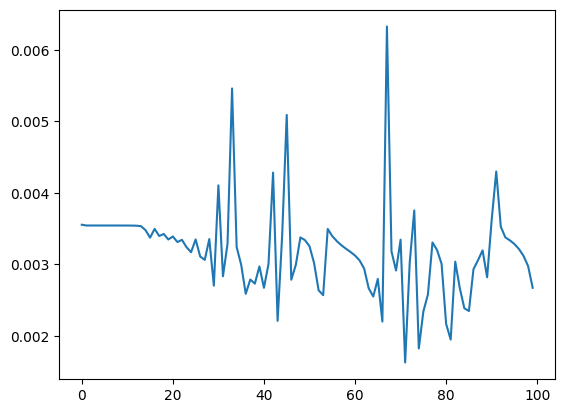

In [23]:
print(f'Min Loss {min(loss_values)}')
plt.plot(loss_values)
plt.show()


## Load trained model

In [36]:
# load saved model
model = RNN(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/dl_final_project/origional_rnn_linear/rnn_model_001_minL.pth'))



<All keys matched successfully>

## Testing

In [37]:
model.eval()

#print(len(test_data))
predictions = []
for i in range(len(test_data)):
    prediction = model(test_data[i][0].unsqueeze(-1))
    predictions.append(prediction)

print(len(predictions))
#print(test_data[3][1])

4


In [38]:
def plot_data_acc(real, predicted, type, xlabel, ylabel):
    real = real.detach().numpy()
    predicted = predicted.detach().numpy()

    x = np.arange(start=0, stop=len(real), step=1) * 1000
    #plt.ylim(min(real[:,0]), max(real[:,0]))

    plt.plot(x, real[:,0], label="Real")
    plt.plot(x, predicted[:,0], "--", label="Predicted")
    plt.title(f"{type} values")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
def plot_data_disp(real, predicted, type, xlabel, ylabel):
    real = real.detach().numpy()
    predicted = predicted.detach().numpy()

    x = np.arange(start=0, stop=len(real), step=1) * 1000
    plt.ylim(-0.015, 0.015)

    plt.plot(x, real[:,1], label="Real")
    plt.plot(x, predicted[:,1], "--", label="Predicted")
    plt.title(f"{type} values")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

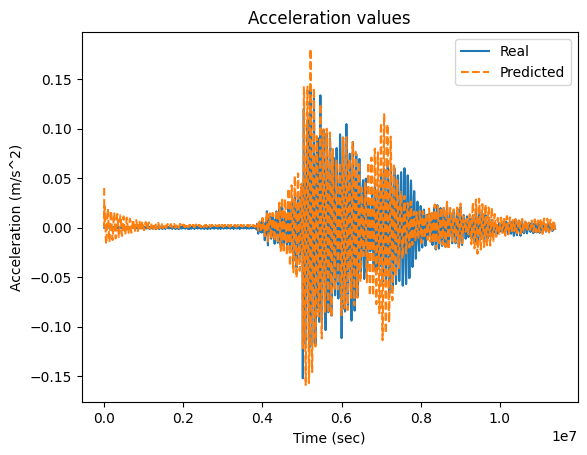

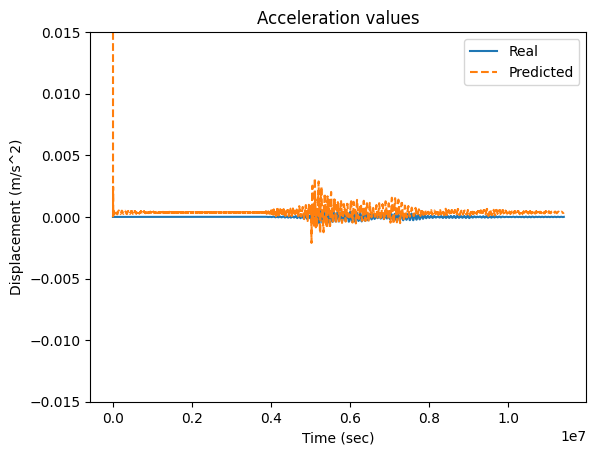

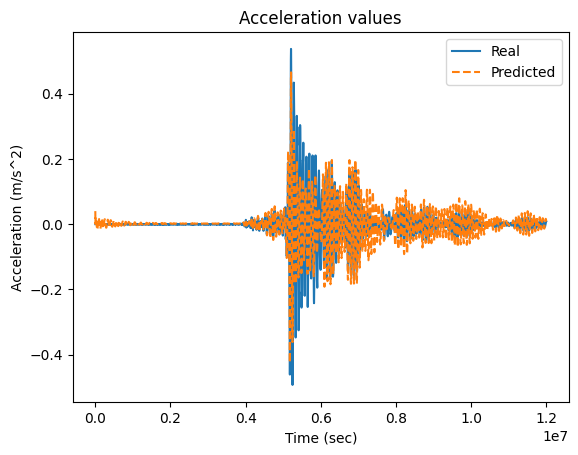

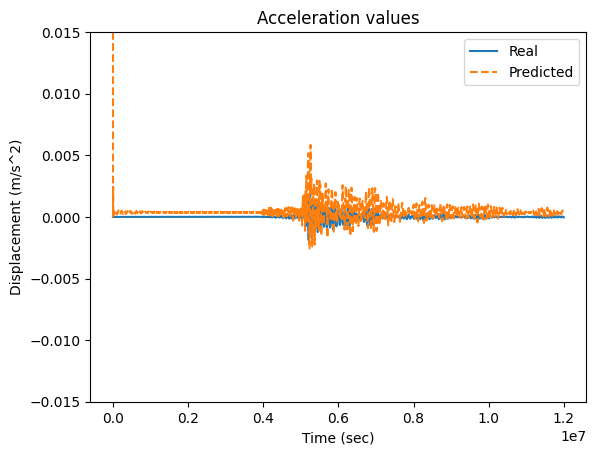

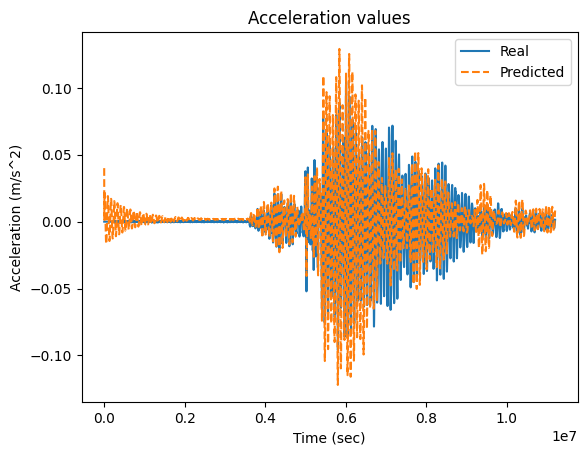

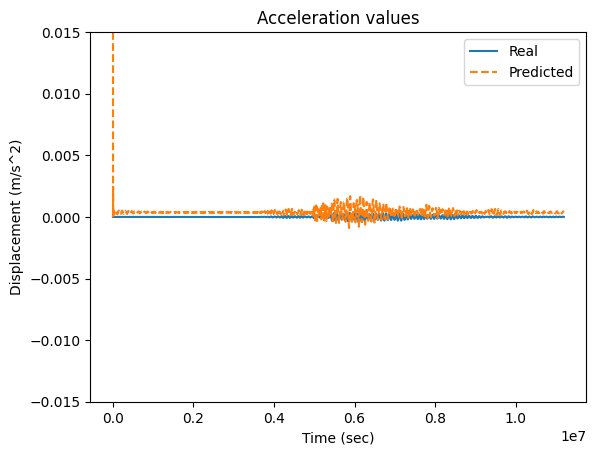

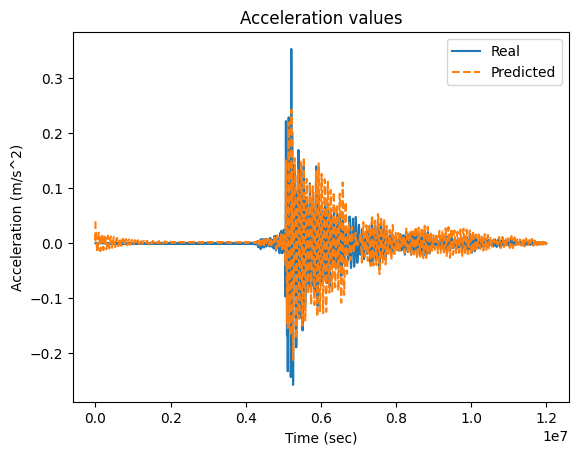

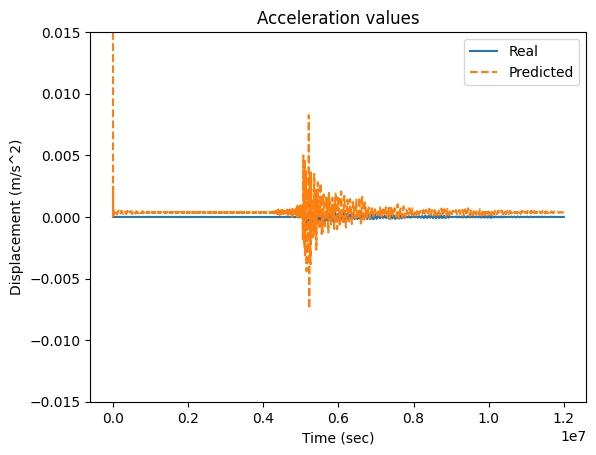

In [39]:
# 4 samples  in test data set.
plot_data_acc(test_data[0][1], predictions[0], "Acceleration", "Time (sec)", "Acceleration (m/s^2)")
plot_data_disp(test_data[0][1], predictions[0], "Acceleration", "Time (sec)", "Displacement (m/s^2)")

plot_data_acc(test_data[1][1], predictions[1], "Acceleration", "Time (sec)", "Acceleration (m/s^2)")
plot_data_disp(test_data[1][1], predictions[1], "Acceleration", "Time (sec)", "Displacement (m/s^2)")

plot_data_acc(test_data[2][1], predictions[2], "Acceleration", "Time (sec)", "Acceleration (m/s^2)")
plot_data_disp(test_data[2][1], predictions[2], "Acceleration", "Time (sec)", "Displacement (m/s^2)")

plot_data_acc(test_data[3][1], predictions[3], "Acceleration", "Time (sec)", "Acceleration (m/s^2)")
plot_data_disp(test_data[3][1], predictions[3], "Acceleration", "Time (sec)", "Displacement (m/s^2)")
